In [12]:
import os
from src import *
from typing import List, Dict
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

"""
COMPAS:
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32 (merged with Other)
Native American       18 (merged with Other)

ADULT:
Amer-Indian-Eskimo  count: 311
White               count: 27816
Asian-Pac-Islander  count: 1039
Black               count: 3124
Other               count: 271
""" 

other = {Tester.OPT_ALL_RACE_SPLITS: True}
Tester.VERBOSE = False
other_fb = other.copy()
other_fb[BaseModel.OPT_FBALANCE] = True
all_metrics = Metrics.get_all_names()

datasets =  [Tester.COMPAS_D, Tester.ADULT_D]
mls_basic = { # bias mitigation method, ML algo, secondary ML alg, preprocessing, other
    "FB Baseline":(Tester.BASE_ML,      Model.LG_R, None, "FairBalance", other_fb), 
    "FairBalance":(Tester.FAIRBALANCE,  Model.LG_R, None, "FairBalance", other_fb), 

    "FM Baseline":(Tester.BASE_ML,      Model.RF_C, None,       None,    other), 
    "FairMask":   (Tester.FAIRMASK,     Model.RF_C, Model.DT_R, None,    other)
}


## ALL METRICS TABLE

In [13]:
# 1 file each for compas and adult tables. 
# func input: dataset, reps, metrics?, filename

def all_race_splits(dataset, reps, filename, metrics = all_metrics, clear_file = True, attrs = None):
    file = os.path.join("results",filename +".csv")
    if clear_file: os.remove(file)
    
    tester = Tester(file)
    for bias_mit, method, method2, pre, oth in list(mls_basic.values()):
        tester.run_test(metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)

In [14]:
# call both
repetitions = 1
# bias mitigated agaist sex and race
##all_race_splits(Tester.COMPAS_D, repetitions, "CompasTESTING")
##all_race_splits(Tester.ADULT_D,  repetitions, "AdultTESTING")
# bias mitigation agaist only race
##all_race_splits(Tester.COMPAS_D, repetitions, "CompasTESTING", ["race"])
##all_race_splits(Tester.ADULT_D,  repetitions, "AdultTESTING", ["race"])

## METRIC GRAPHS

In [29]:

def make_graph(plt,baselines: List[float], results: Dict[str,List[float]], labels: List[str], results_mit_for_all = None):
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, baselines, align='center', alpha=0.5, label = "baseline")
    #plt.xticks(y_pos, labels)
    plt.set(xticks=x_pos, xticklabels=labels)
    plt.tick_params(rotation=23)
   

    for k, v in results.items():
        plt.plot(v, linestyle='--', marker='o',label="bias mit: "+k+" vs all")

    if results_mit_for_all:
        plt.plot(results_mit_for_all, c = 'k', linestyle='--', marker='o',label="bias mit for all")

    plt.legend(bbox_to_anchor=(0, 1.15, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=1)
    return plt


In [16]:

def _graph_all_race_splits(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    tester = Tester(os.path.join("results","history" +".csv"))
    
    bias_mit, method, method2, pre, oth = baseline
    tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)
    baseline_results = tester.get_eval_for_each_race_split(metric_name)
    races = list(baseline_results.keys())

    #results = {key:list(baseline_results.values()) for key in races}
    results = {key:[] for key in races}
    bias_mit, method, method2, pre, oth = mitigation
    for race in races:
        tester.update_training_race_split(race)
        tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        results[race] = list(tester.get_eval_for_each_race_split(metric_name).values())

    
    return list(baseline_results.values()), results, races, tester


In [17]:
def graph_all_race_splits(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    baseline, results, races, _ = _graph_all_race_splits(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval)

    make_graph(plt,baseline, results, races)

    plt.set_ylabel(metric_name)
    plt.set_title(title)
    plt.autoscale(enable=True) 
    return plt

In [32]:

def graph_all_race_splits_mit_for_all(plt,dataset, baseline, mitigation, metric_name, title, reps, metrics_to_eval=all_metrics):
    baseline, results, races, tester = _graph_all_race_splits(plt,dataset, baseline, mitigation, 'race|'+metric_name, title, reps, ['race'], metrics_to_eval)
    bias_mit, method, method2, pre, oth = mitigation
    oth[tester.OPT_SPLIT_RACE_COLS] = True
    tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=races)
    results_mit_for_all = []
    for r in races:
        results_mit_for_all.append(tester.get_eval(r+'|'+metric_name))

    print(results_mit_for_all)
    make_graph(plt,baseline, results, races, results_mit_for_all)

    plt.set_ylabel(metric_name)
    plt.set_title(title)
    plt.autoscale(enable=True) 
    return plt


In [19]:


def run_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(20, 4.5, forward=True)
    fig.subplots_adjust(wspace=0.175, hspace=0)
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_race_splits(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask effect on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance effect on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask effect on Adult", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance effect on Adult", reps, attrs, metrics_to_eval)

    plt.show()

def run_fb_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(14, 7, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_race_splits(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance effect on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance effect on Adult", reps, attrs, metrics_to_eval)

    plt.show()


In [20]:
def run_experiment_group_mit_for_all(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(20, 4.5, forward=True)
    fig.subplots_adjust(wspace=0.175, hspace=0)
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_race_splits_mit_for_all(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask effect on COMPAS", reps,  metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance effect on COMPAS", reps,  metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask effect on Adult", reps,  metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance effect on Adult", reps,  metrics_to_eval)

    plt.show()

def run_fb_experiment_group_mit_for_all(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(14, 7, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_race_splits_mit_for_all(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance effect on COMPAS", reps,  metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance effect on Adult", reps,  metrics_to_eval)

    plt.show()

## GRAPH CHANGE IN METRIC

In [21]:
def make_change_graph(plt, baselines, results, races, bias_mit_race, max_val): 
    colors = cm.rainbow(np.linspace(0, 1, len(races)+1))

    ls = np.linspace(-max_val, max_val, 1000)
    zeros = np.zeros_like(ls)
    plt.plot(ls, zeros, color='0.5')
    plt.plot(zeros, ls, color='0.5')

   # plt.fill_between(ls, zeros, ls, where=(ls > zeros), color='C0', alpha=0.3, interpolate=True)
    plt.fill_between(ls, zeros, ls, color='0.5', alpha=0.05, interpolate=True)
    plt.fill_between(ls, zeros, -ls, color='0.5', alpha=0.05, interpolate=True, label= "bias decreased")
    plt.fill_between(ls, ls, zeros + max_val, where=(ls > zeros), color='g', alpha=0.05, interpolate=True, label="bias increased favourably")
    plt.fill_between(ls, -ls, zeros + max_val, where=(ls < zeros), color='g', alpha=0.05, interpolate=True)
    plt.fill_between(ls, -ls, zeros - max_val, where=(ls > zeros), color='r', alpha=0.05, interpolate=True, label="bias increased unfavourably")
    plt.fill_between(ls, ls, zeros - max_val, where=(ls < zeros), color='r', alpha=0.05, interpolate=True)

    # plotting only bias mit against white
    results_per_race = np.array(results[bias_mit_race]).T
    baselines_per_race = np.array(baselines).T
    first = True
    for i in range(len(races)): # bias mitigation against each race
        b, r = baselines_per_race[i], results_per_race[i]
        plt.scatter(b, r, marker='.', color= colors[i], alpha=0.4, label= "bias towards "+races[i])

    for i in range(len(races)): # bias mitigation against each race
        b, r = baselines_per_race[i], results_per_race[i]
        if first: 
            plt.scatter(np.mean(b, axis=0),  np.mean(r, axis=0), marker='D', color= '0.3', alpha=0.5, label= "avg bias")
            first = False
        plt.scatter(np.mean(b, axis=0),  np.mean(r, axis=0), marker='D', color= colors[i], s = 45)
        

    plt.legend()
    plt.legend(bbox_to_anchor=(0, 1.15, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=1)
    return plt

In [22]:
def graph_all_metric_changes(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    results_out = None
    baselines_out = []
    max_val = 0
    for r in range(reps):   
        tester = Tester(os.path.join("results","change_history" +".csv")) 
        
        bias_mit, method, method2, pre, oth = baseline
        tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, 1, same_data_split=True, data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        baselines = tester.get_eval_for_each_race_split(metric_name)
        baselines_vals = np.array(list(baselines.values()))
        max_val = max(max_val, np.amax(np.abs(baselines_vals)))

        baselines_out.append(baselines_vals)
        races = list(baselines.keys())
        if not results_out:
            results_out = {bias_mit_race:[] for bias_mit_race in races}

        bias_mit, method, method2, pre, oth = mitigation
        bias_mit_race =  races[0] # bias mit against white
        #for bias_mit_race in races:
        tester.update_training_race_split(bias_mit_race)
        tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, 1, same_data_split=True, data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        result = np.array(list(tester.get_eval_for_each_race_split(metric_name).values()))   
        max_val = max(max_val, np.amax(np.abs(result)))
        results_out[bias_mit_race].append(result)  

    make_change_graph(plt, baselines_out, results_out, races, bias_mit_race, max_val)

    plt.set_ylabel(metric_name + " after bias mitigation")
    plt.set_xlabel("baseline " + metric_name)
    plt.set_title(title)
    plt.autoscale(enable=True) 
    return plt

In [23]:

def run_change_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(20, 5, forward=True)
    fig.subplots_adjust(wspace=0.175, hspace=0)
    
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_metric_changes(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask Caucasian vs non-Caucasian bias mit. on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance Caucasian vs non-Caucasian bias mit. on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask White vs non-White bias mit. on Adult", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance White vs non-White bias mit. on Adult", reps, attrs, metrics_to_eval)

    plt.show()

def run_change_fb_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(14, 7, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_metric_changes(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance Caucasian vs non-Caucasian bias mit. on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance White vs non-White bias mit. on Adult", reps, attrs, metrics_to_eval)

    plt.show()

## RUNNING EXPERIMENTS

in test
African-American    702
Caucasian           532
Hispanic            120
Other                83
Name: race, dtype: int64
['race']
['race']
['race']
['race']
['race']
['Caucasian', 'Other', 'Hispanic', 'African-American']
[0.19064, 0.09221, 0.03652, -0.20916]
in test
African-American    722
Caucasian           494
Hispanic            130
Other                91
Name: race, dtype: int64
['race']
['race']
['race']
['race']
['race']
['Caucasian', 'Other', 'Hispanic', 'African-American']
[0.00622, 0.06549, -0.05338, -0.00358]
in test
White                 5591
Black                  589
Asian-Pac-Islander     213
Amer-Indian-Eskimo      65
Other                   55
Name: race, dtype: int64
['race']
['race']
['race']
['race']
['race']
['race']
['White', 'Asian-Pac-Islander', 'Black', 'Amer-Indian-Eskimo', 'Other']
[0.08475, 0.02585, -0.11047, -0.10096, -0.12337]
in test
White                 5575
Black                  610
Asian-Pac-Islander     209
Amer-Indian-Eskimo      69
Other 

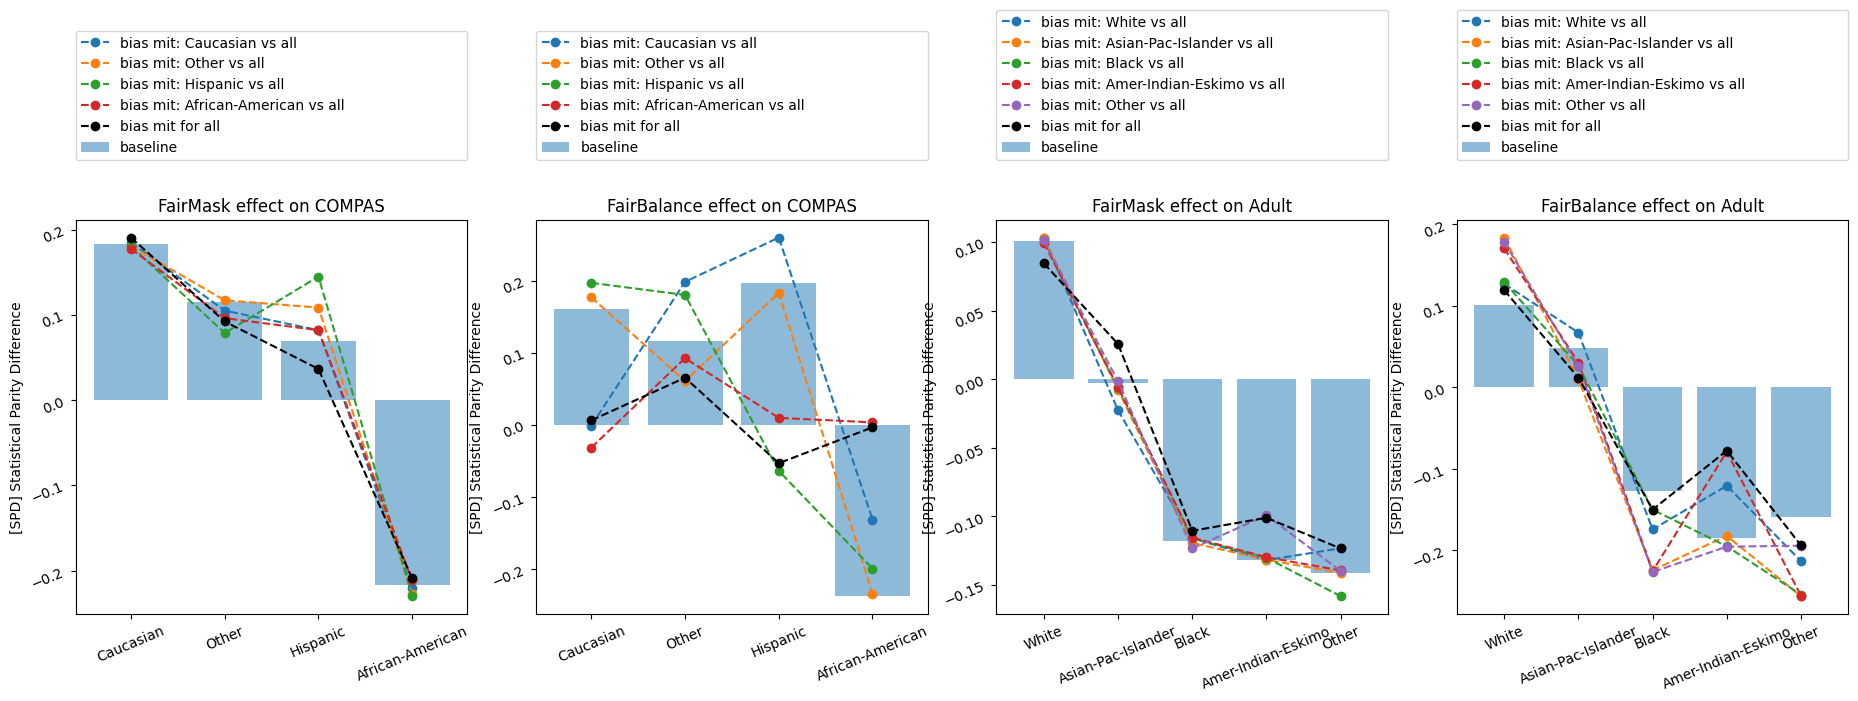

In [34]:
reps = 1
metric = Metrics.SPD
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])

in test
African-American    714
Caucasian           503
Hispanic            136
Other                84
Name: race, dtype: int64
['race']
['race']
['race']
['race']
['race']
['Caucasian', 'Other', 'Hispanic', 'African-American']
[0.11763, 0.08133, 0.11823, -0.18664]
in test
African-American    721
Caucasian           483
Hispanic            138
Other                95
Name: race, dtype: int64
['race']
['race']
['race']
['race']
['race']
['Caucasian', 'Other', 'Hispanic', 'African-American']
[-0.06285, 0.05591, 0.09027, 0.01235]
in test
White                 5580
Black                  595
Asian-Pac-Islander     231
Other                   54
Amer-Indian-Eskimo      53
Name: race, dtype: int64
['race']
['race']
['race']
['race']
['race']
['race']
['White', 'Asian-Pac-Islander', 'Black', 'Amer-Indian-Eskimo', 'Other']
[0.03905, 0.03969, -0.06882, -0.25103, -0.28635]
in test
White                 5566
Black                  600
Asian-Pac-Islander     221
Amer-Indian-Eskimo      68
Other  

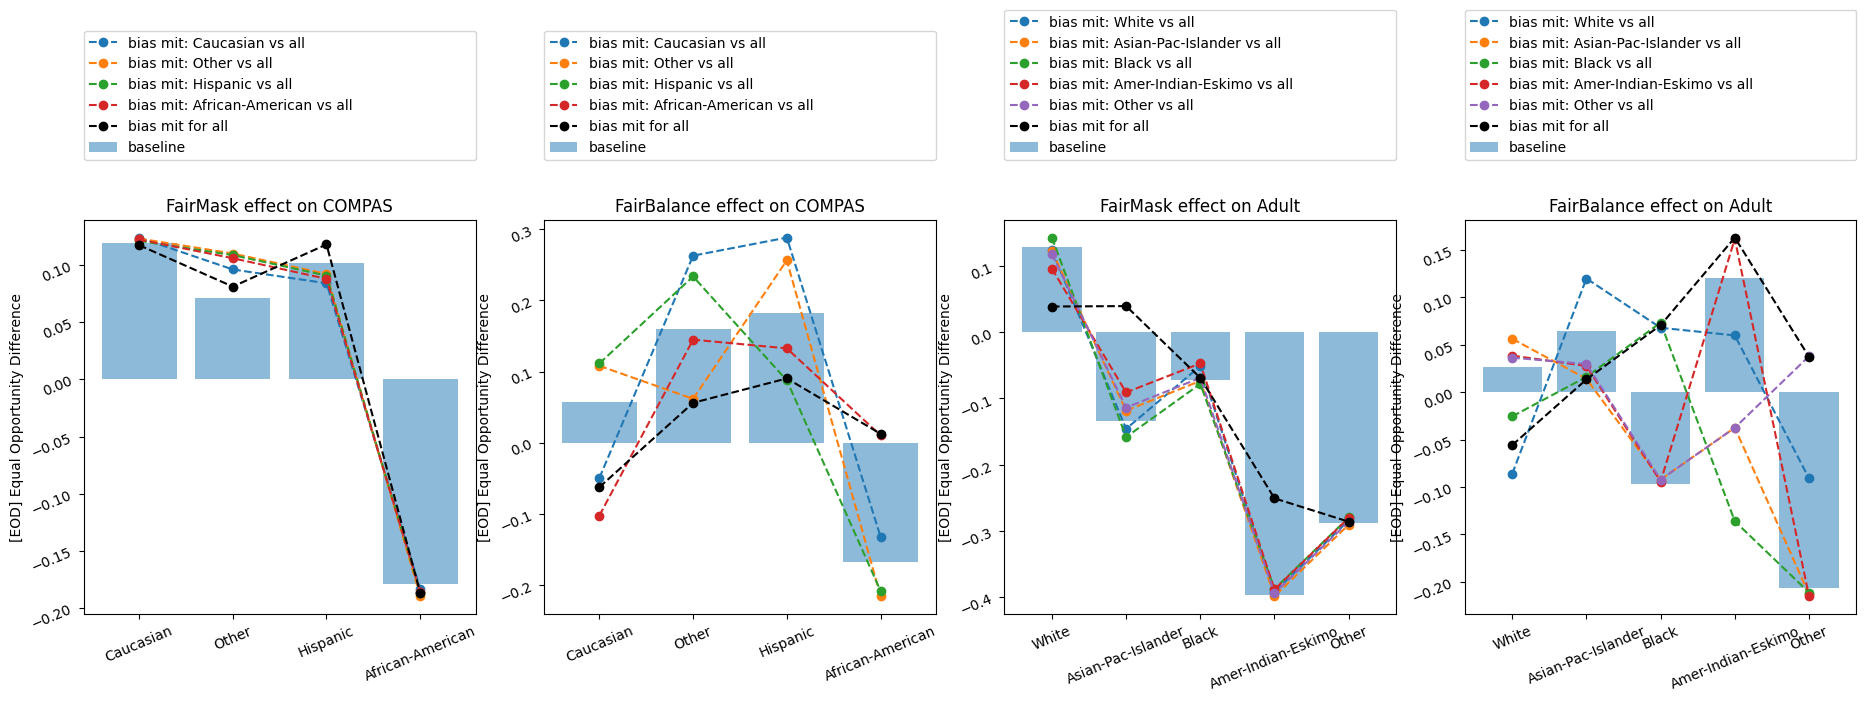

In [35]:
reps = 1
metric = Metrics.EOD
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])

in test
African-American    697
Caucasian           519
Hispanic            119
Other               102
Name: race, dtype: int64
['race']
['race']
['race']
['race']
['race']
['Caucasian', 'Other', 'Hispanic', 'African-American']
[0.6666666666666666, 0.7941176470588235, 0.680672268907563, 0.49928263988522237]
in test
African-American    745
Caucasian           494
Hispanic            111
Other                87
Name: race, dtype: int64
['race']
['race']
['race']
['race']
['race']
['Caucasian', 'Other', 'Hispanic', 'African-American']
[0.4939271255060729, 0.5977011494252874, 0.5045045045045045, 0.508724832214765]
in test
White                 5546
Black                  651
Asian-Pac-Islander     198
Amer-Indian-Eskimo      61
Other                   57
Name: race, dtype: int64
['race']
['race']
['race']
['race']
['race']
['race']
['White', 'Asian-Pac-Islander', 'Black', 'Amer-Indian-Eskimo', 'Other']
[0.1963577353047241, 0.2474747474747475, 0.07526881720430108, 0.11475409836065574, 0.03

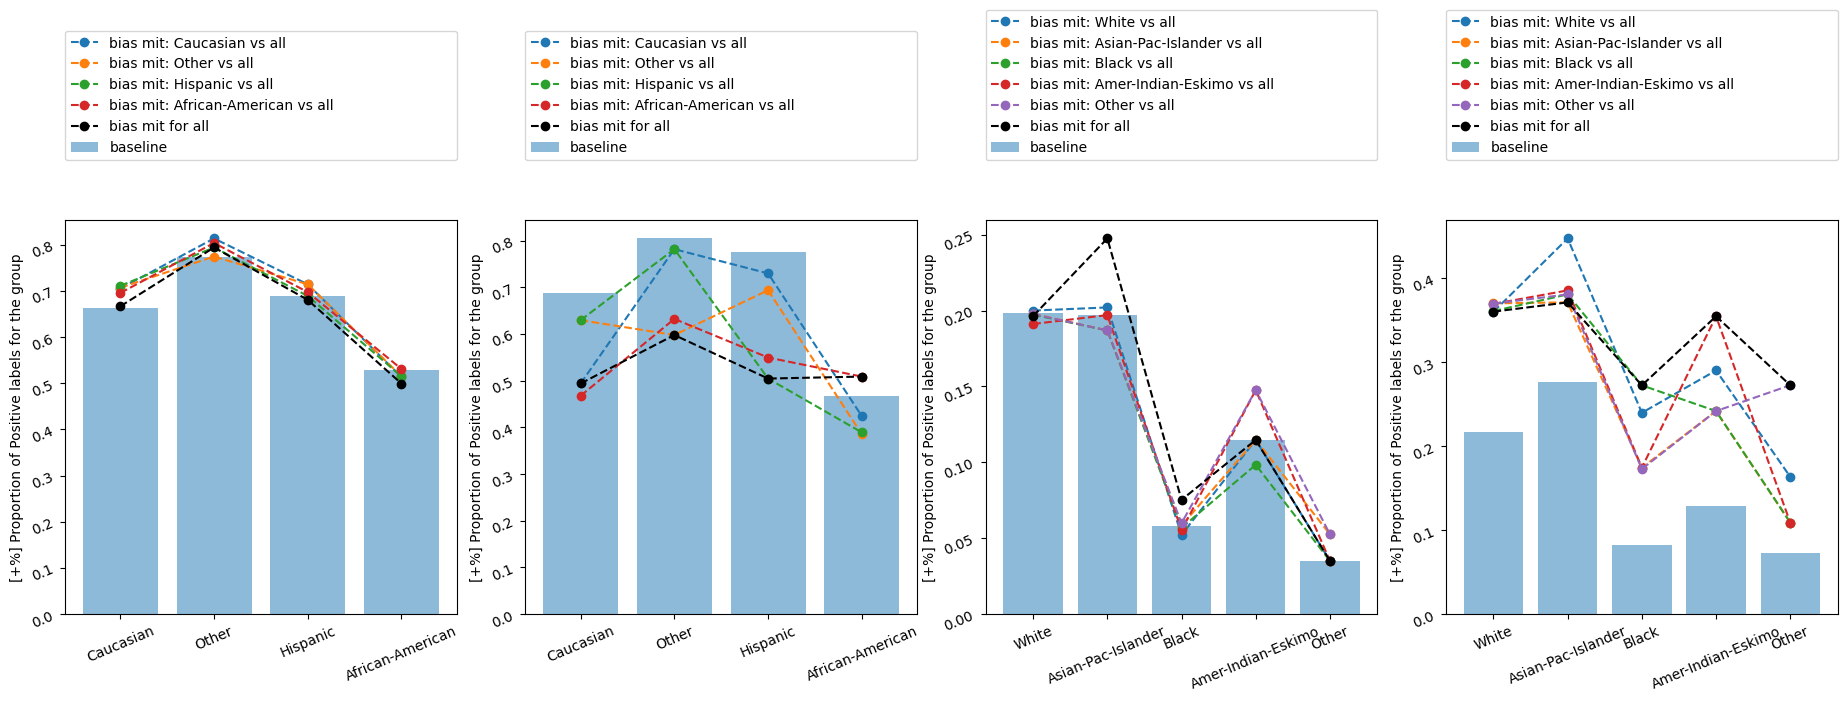

In [ ]:
reps = 1
metric = Metrics.POS
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])

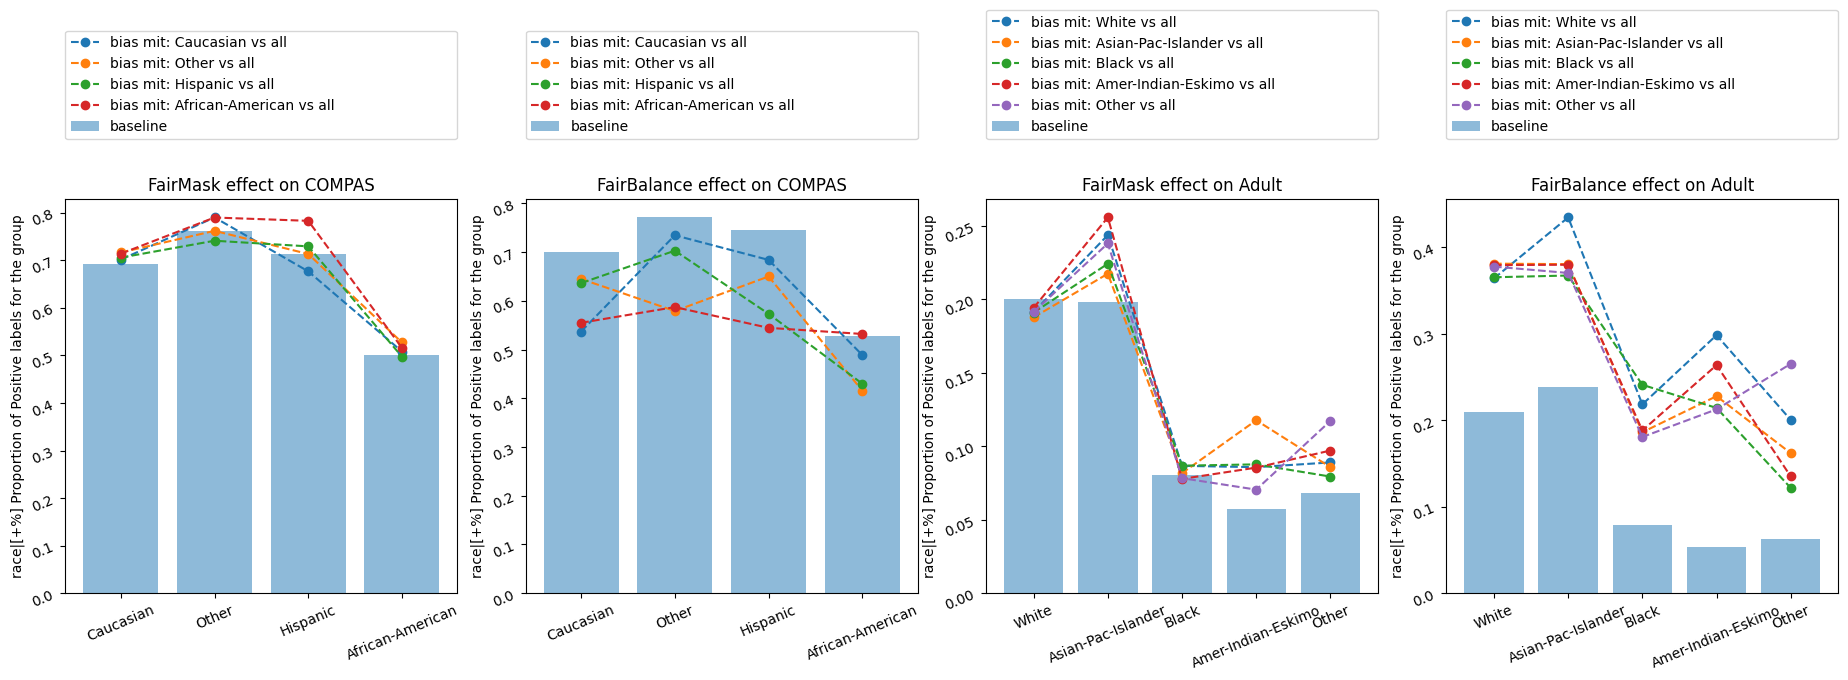

In [300]:
# proportion of positive lables for each race for one run
reps = 5
metric = 'race|'+Metrics.POS
m_to_eval = Metrics.POS
run_experiment_group(reps, metric, attrs =  ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
##run_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

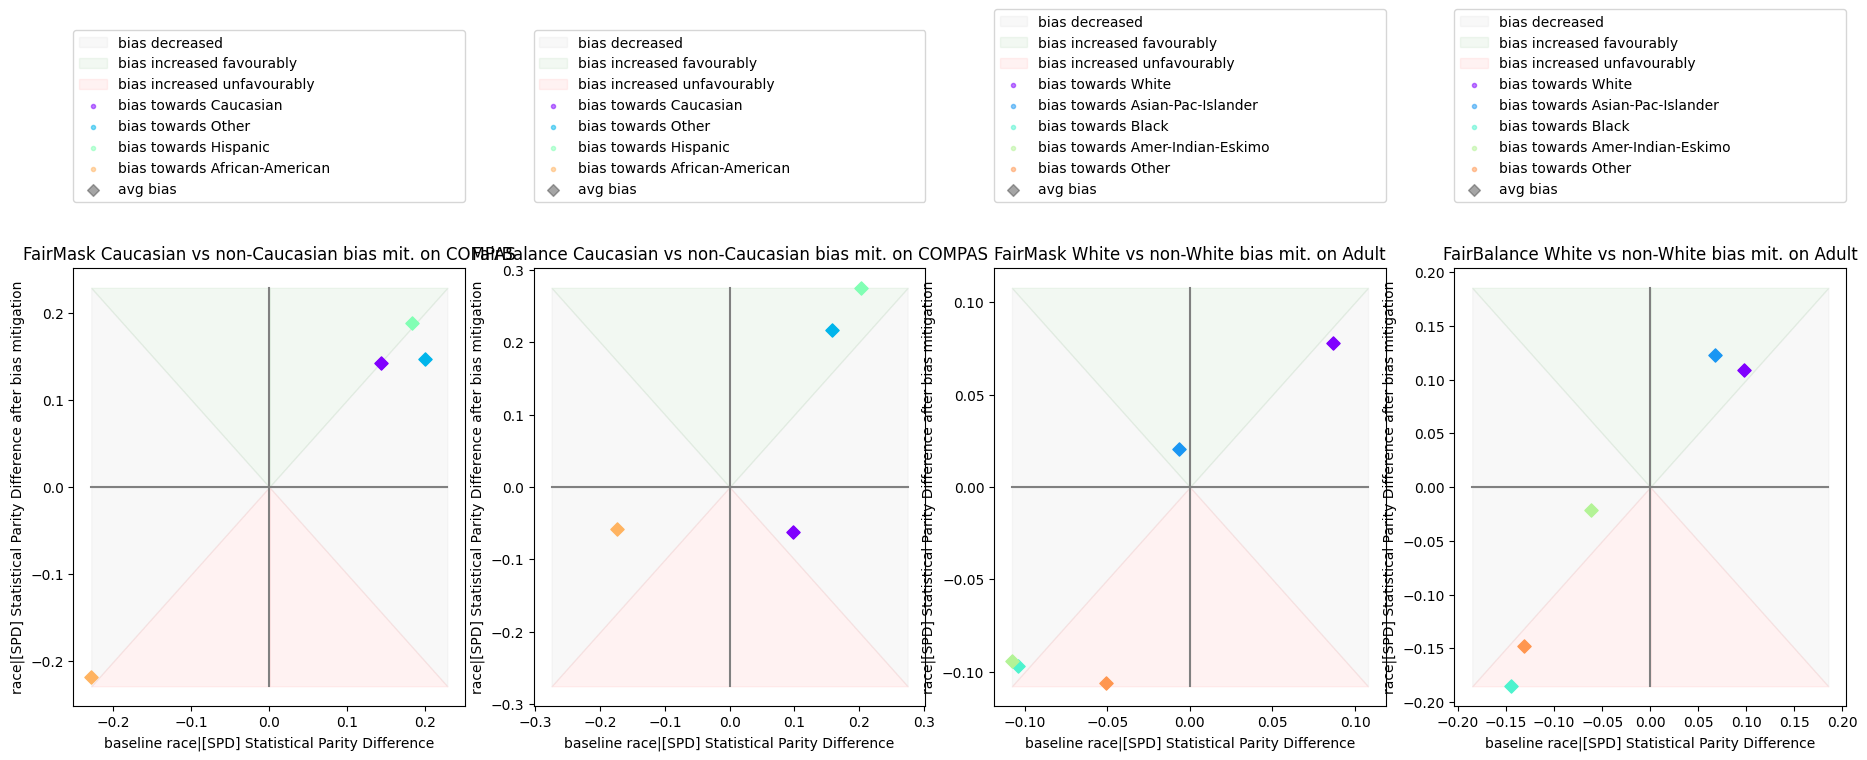

In [308]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 1
metric = 'race|'+Metrics.SPD
m_to_eval = Metrics.SPD
run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
#run_change_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

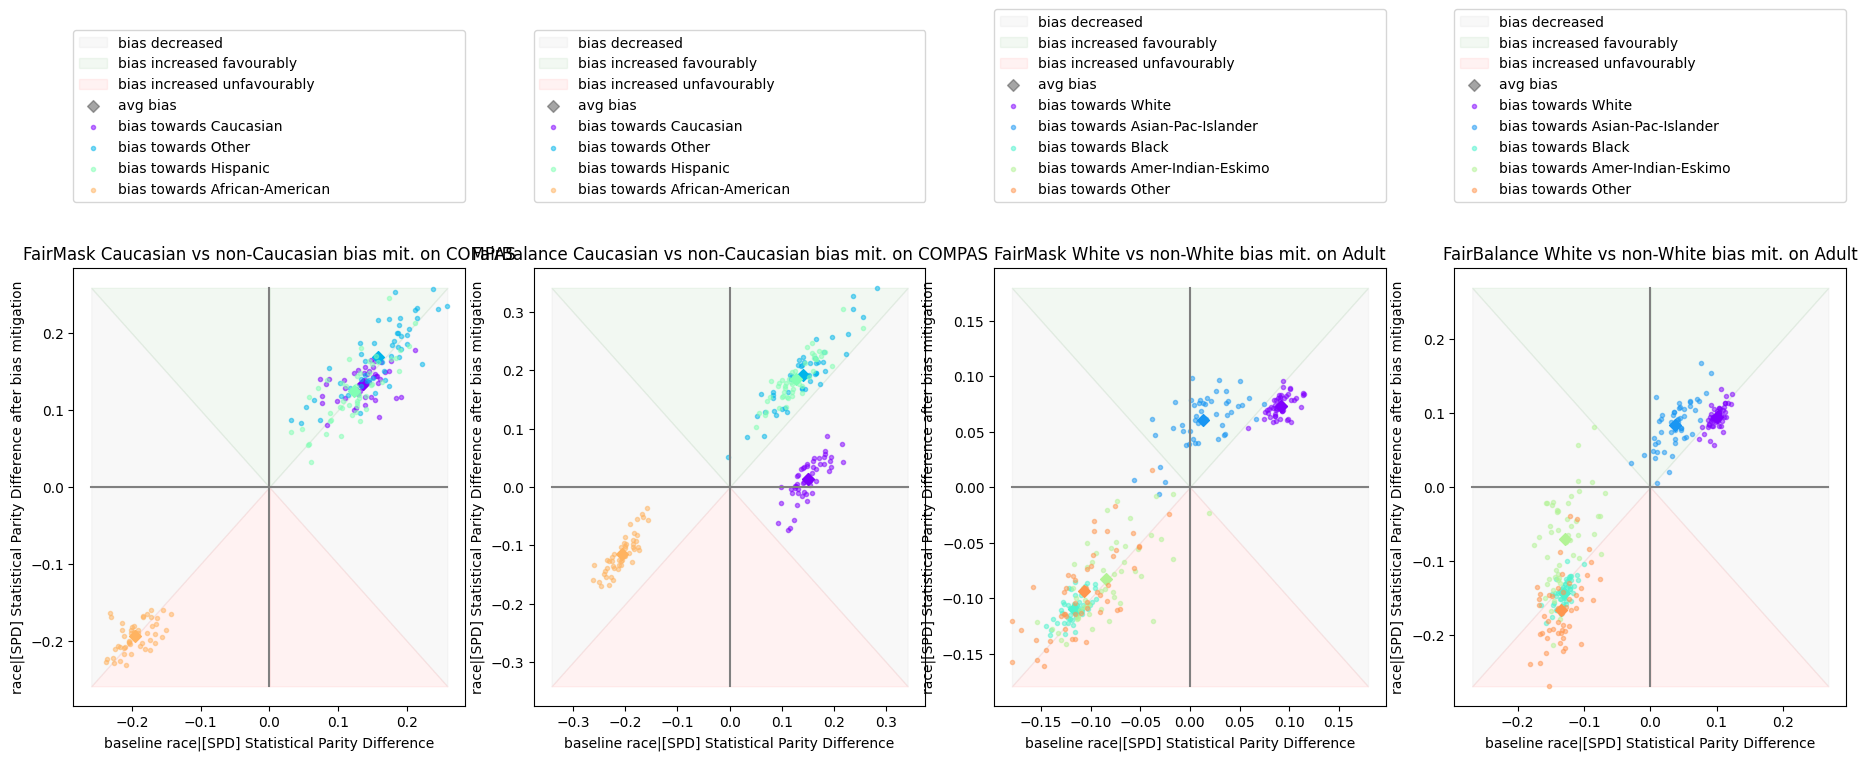

In [301]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 50
metric = 'race|'+Metrics.SPD
m_to_eval = Metrics.SPD
run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
#run_change_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

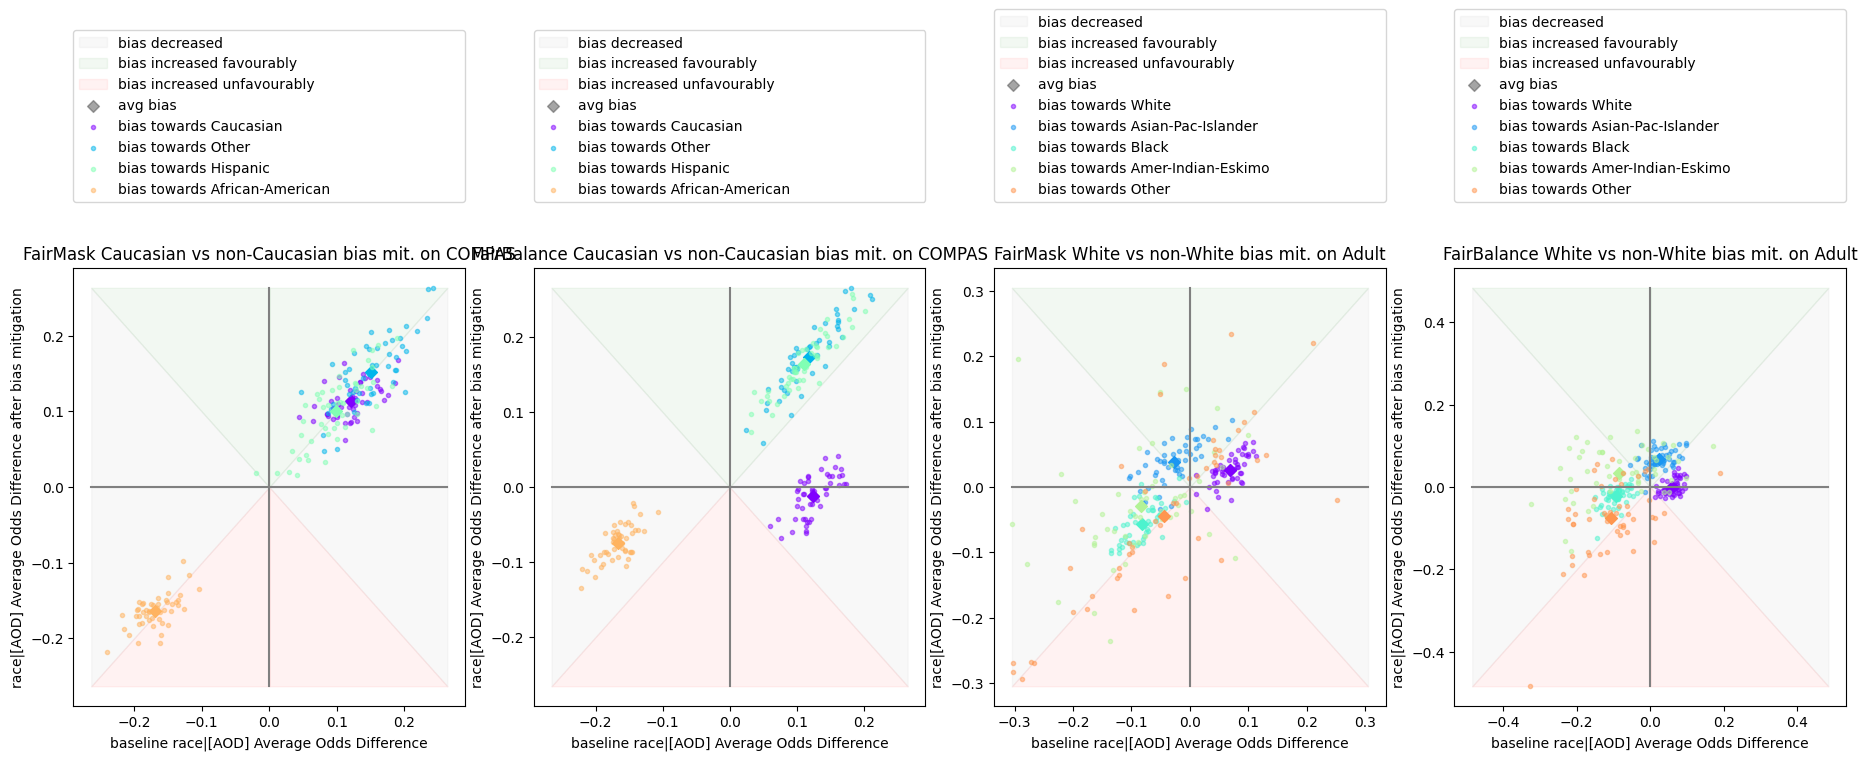

In [302]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 50
metric = 'race|'+Metrics.AOD
m_to_eval = Metrics.AOD
run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
#run_change_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

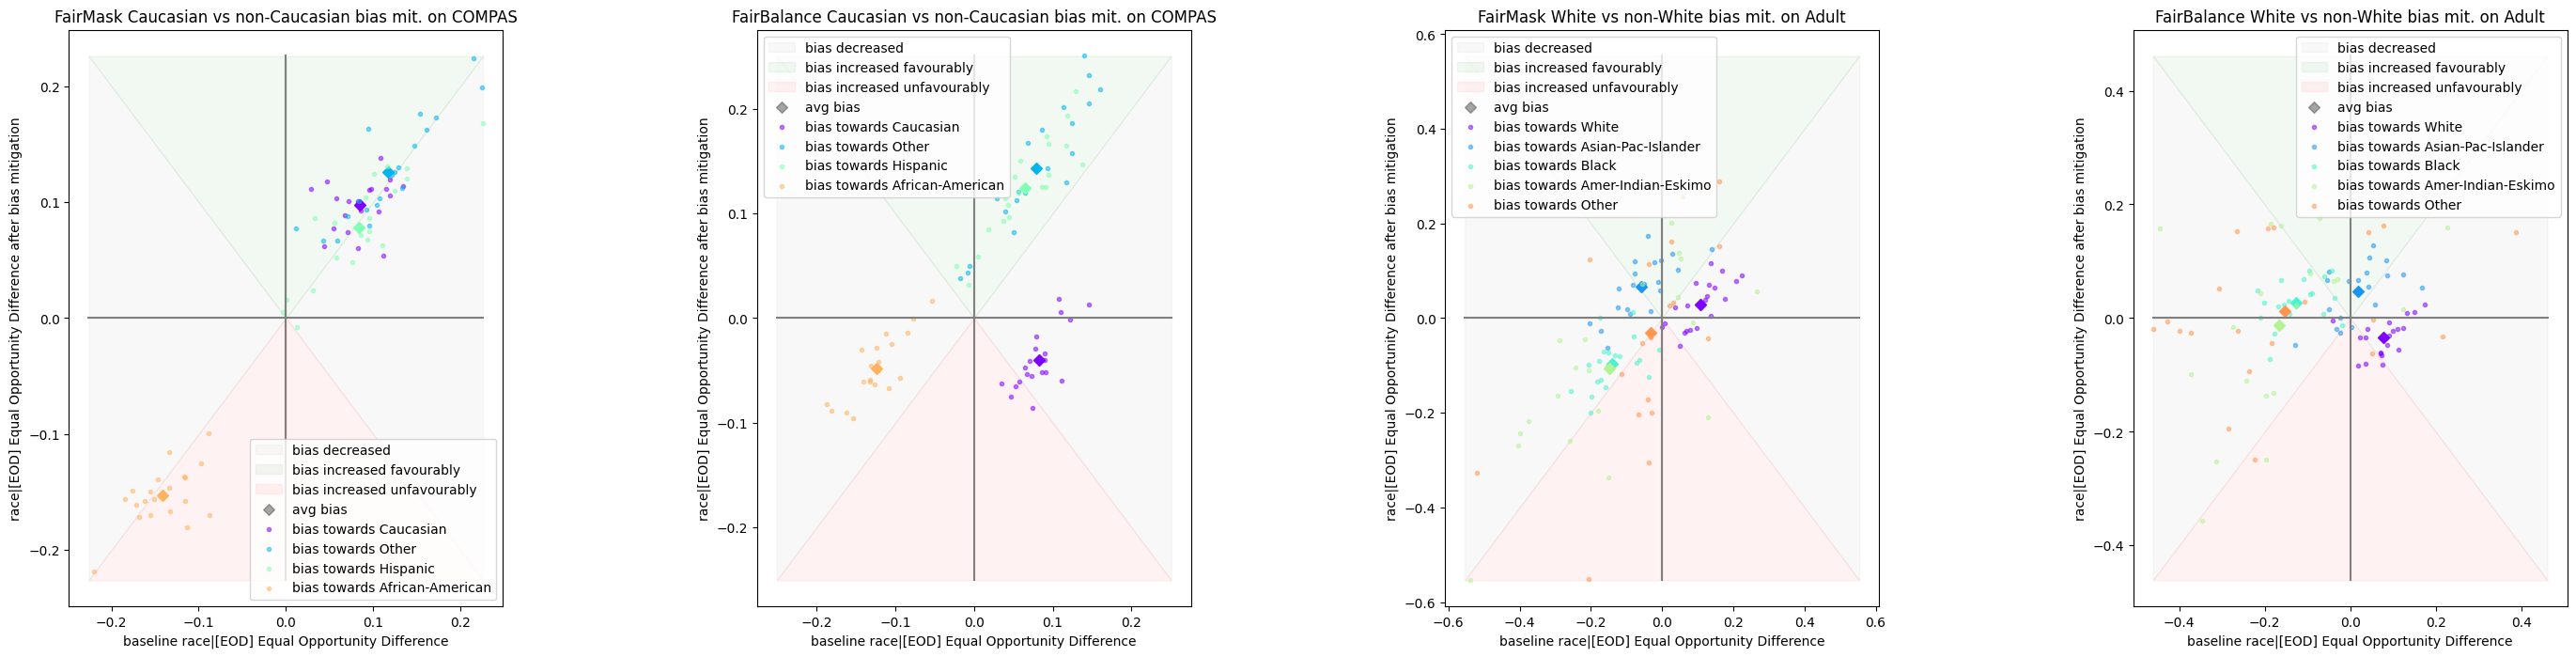

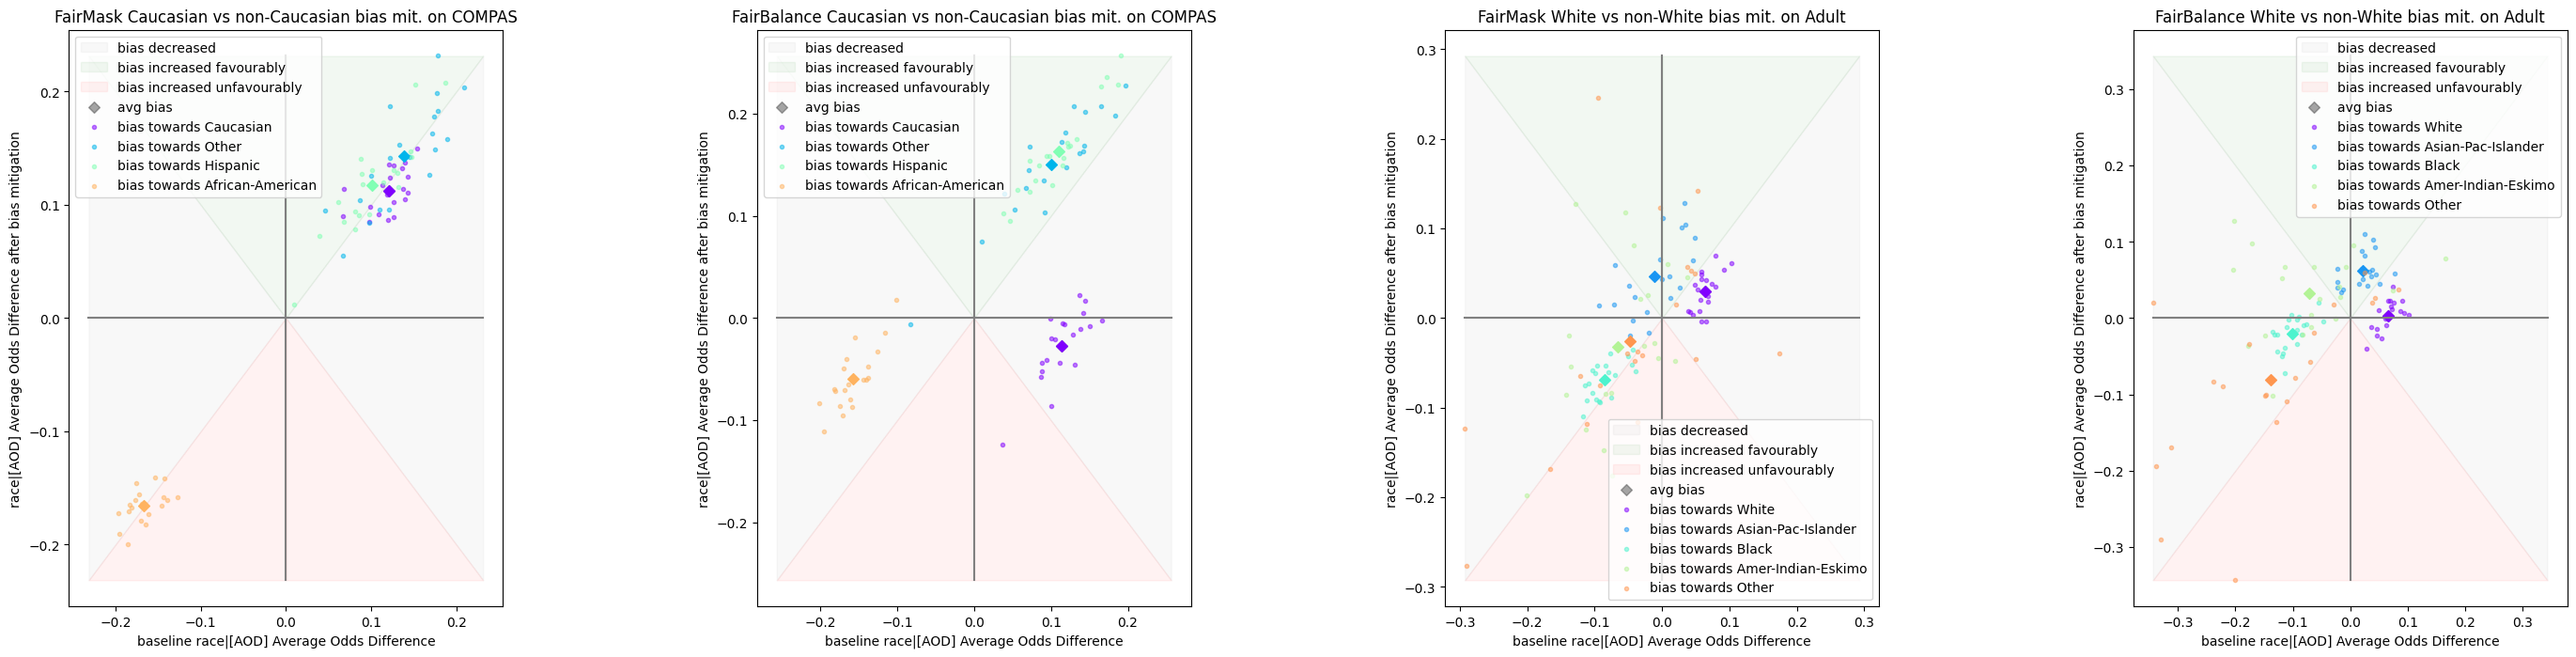

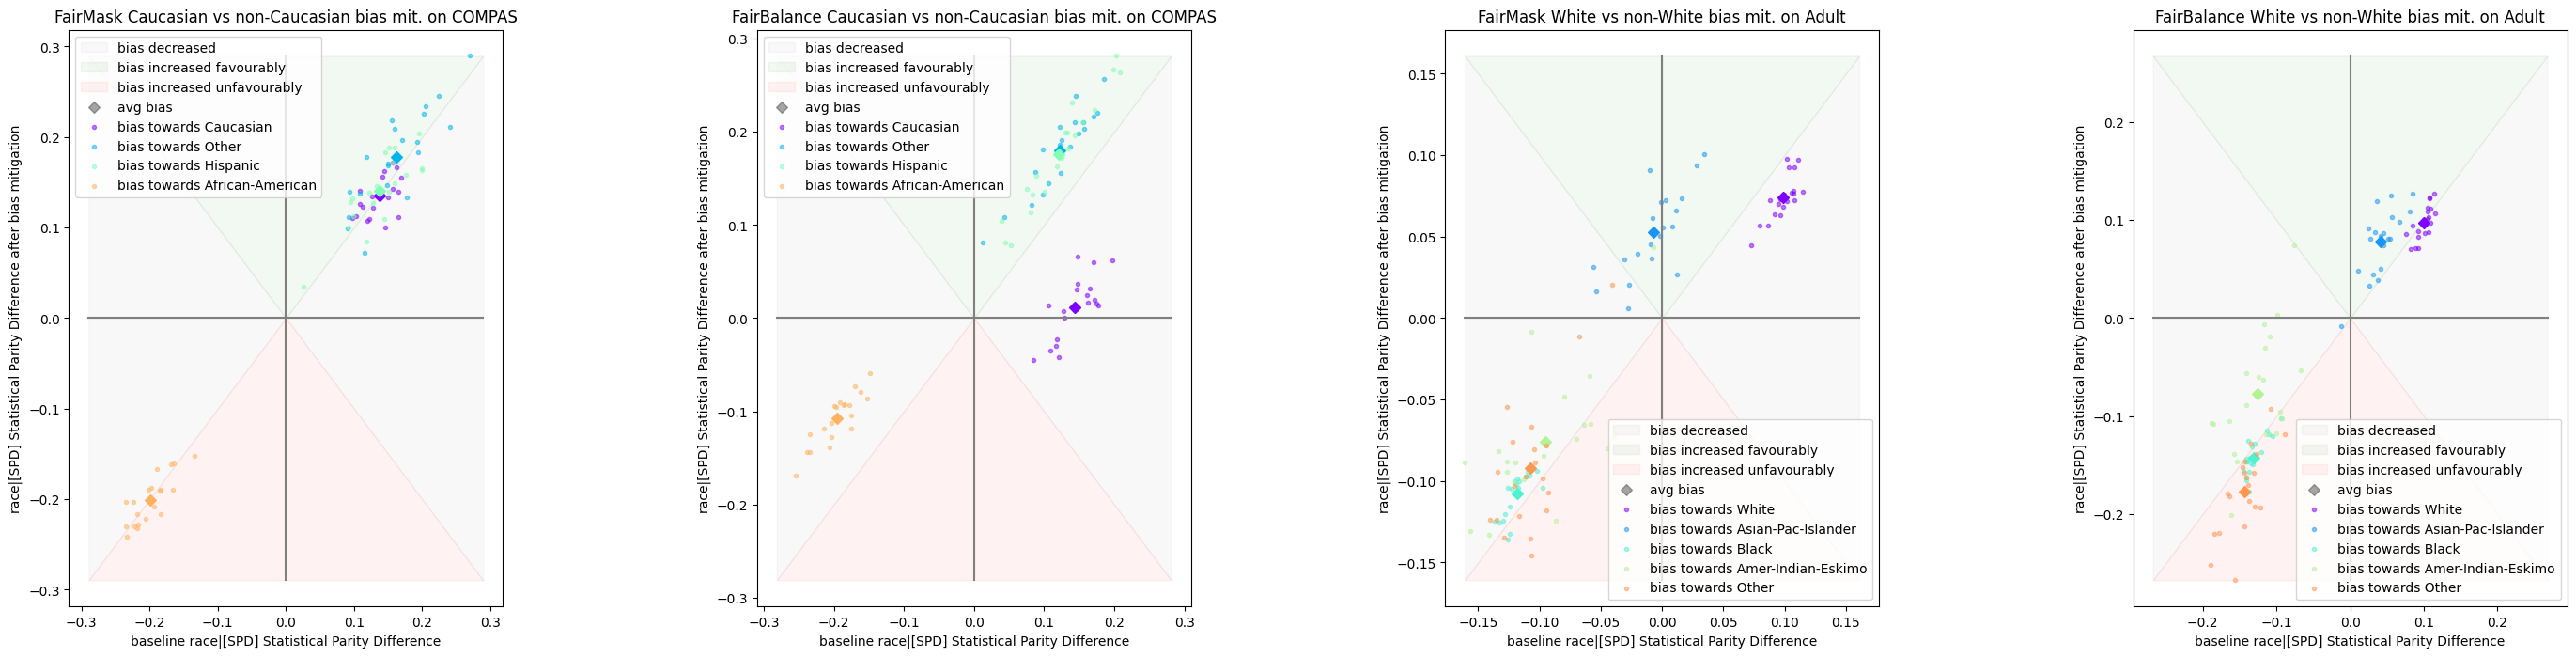

In [212]:
reps = 20
for m in [Metrics.EOD, Metrics.AOD, Metrics.SPD]:
    metric = 'race|'+m
    m_to_eval = m
    run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])


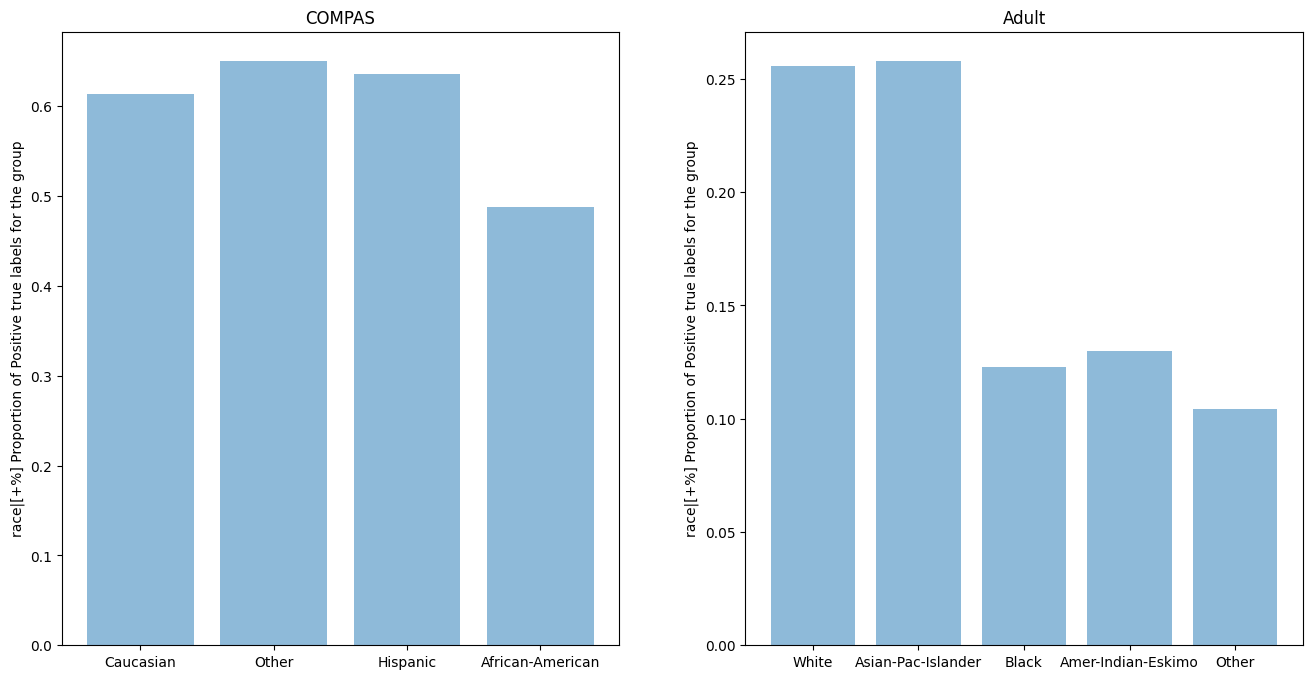

In [12]:
reps = 15
metric = 'race|'+Metrics.T_POS
m_to_eval = Metrics.T_POS
run_fb_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])

In [ ]:
reps = 1
metric = Metrics.DF # 
m_to_eval = metric
run_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
run_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

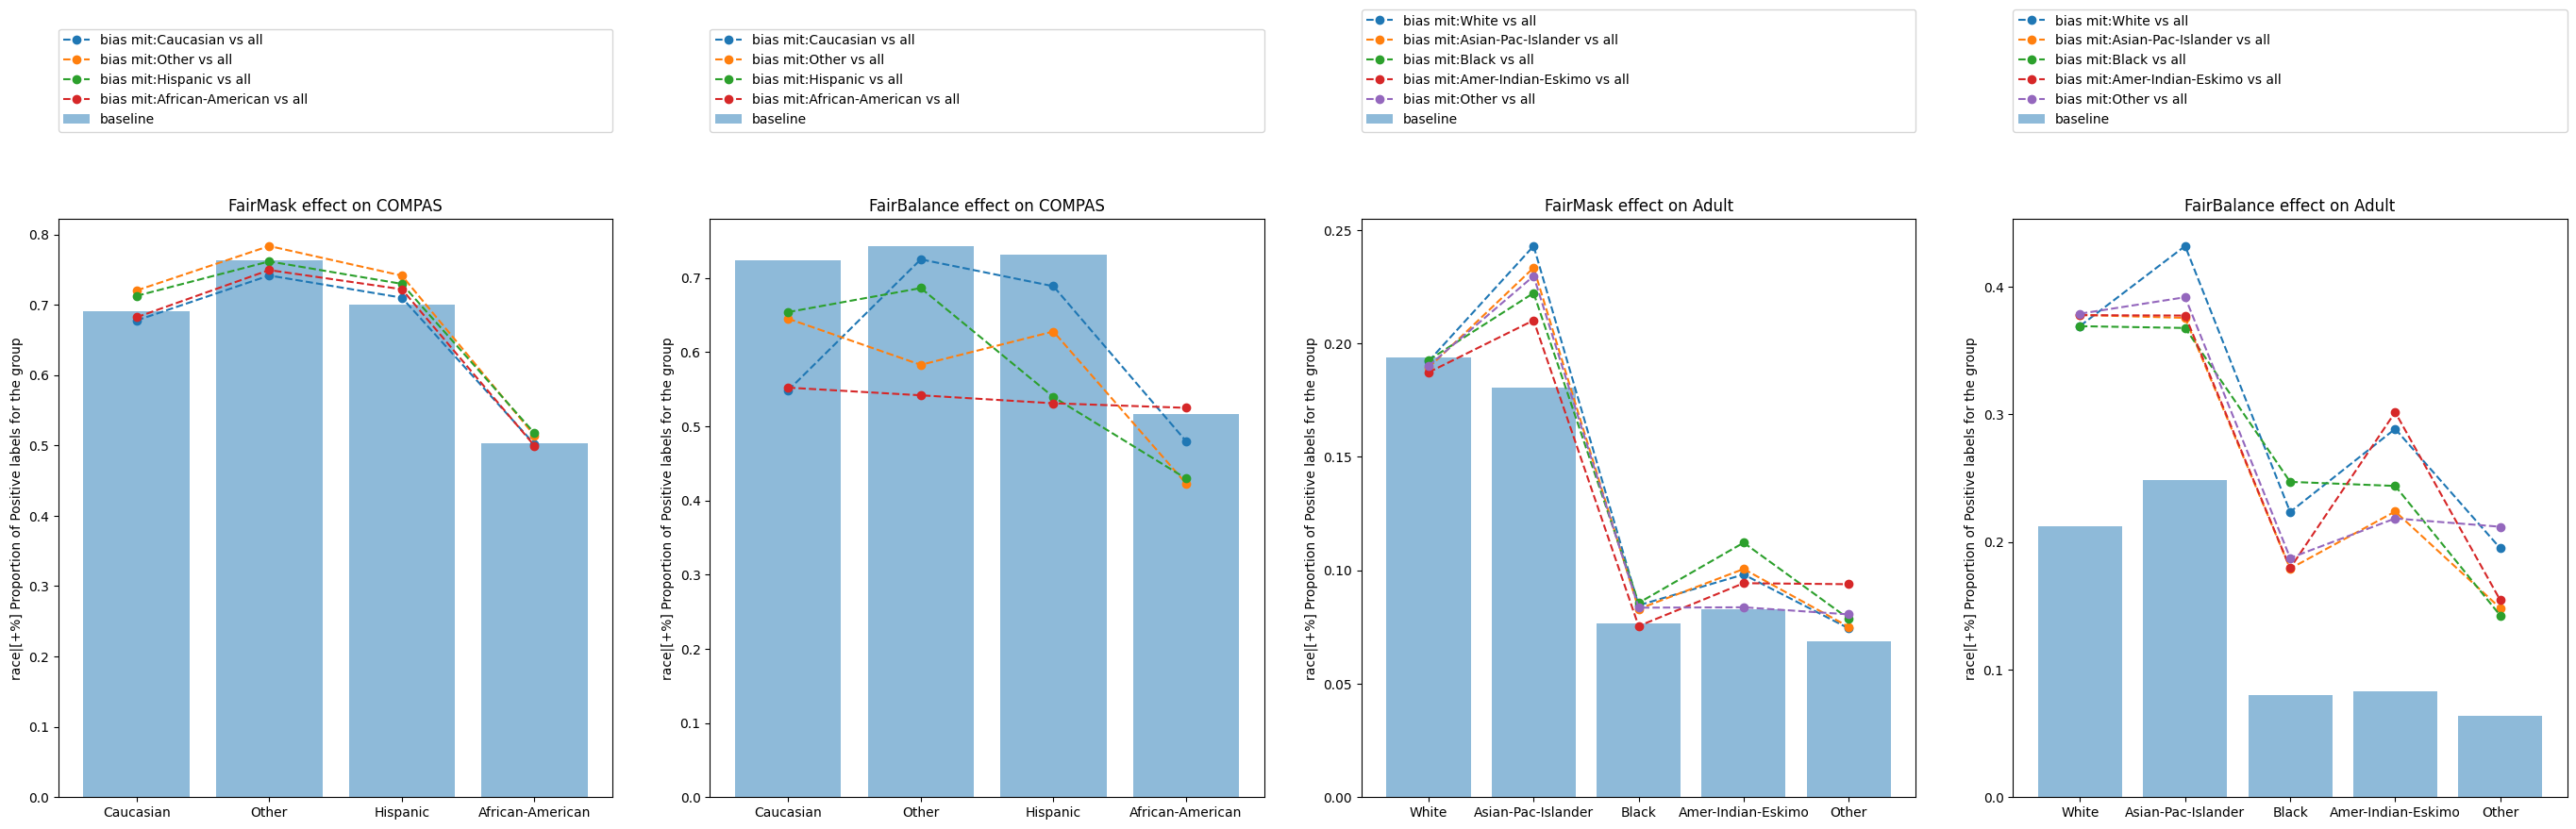

In [261]:
# proportion of positive lables for each race
reps = 20
metric = 'race|'+Metrics.POS
m_to_eval = Metrics.POS
run_experiment_group(reps, metric, attrs= ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
##run_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

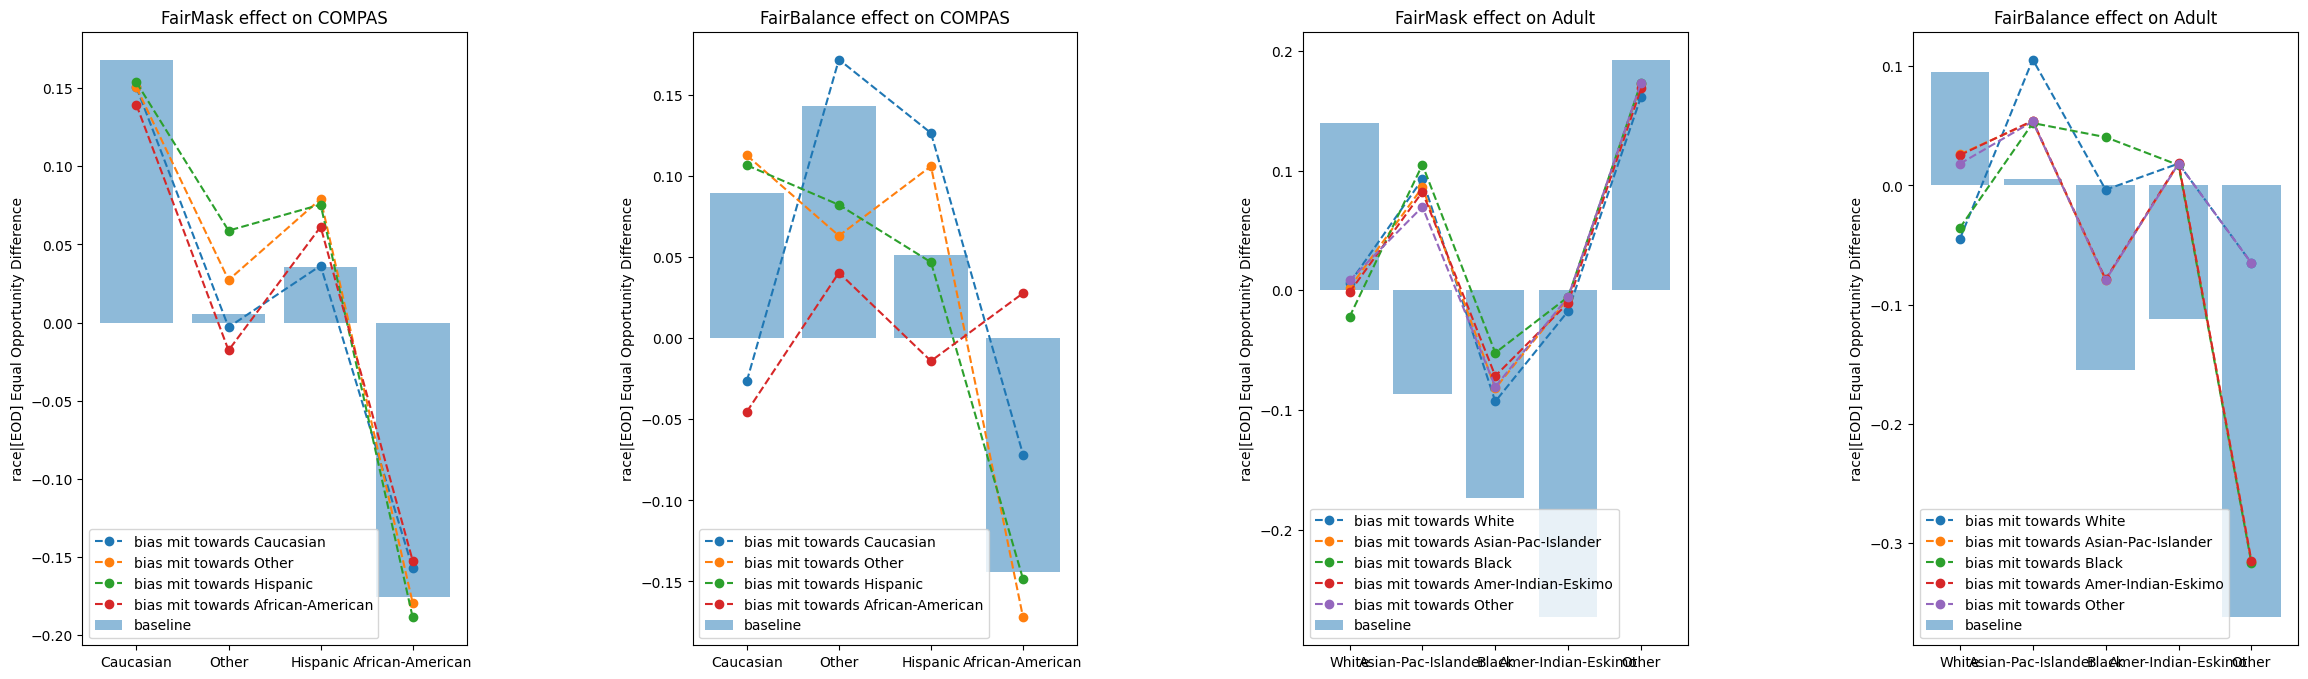

In [ ]:
reps = 1
metric =  'race|'+Metrics.EOD
run_experiment_group(reps, metric, metrics_to_eval=[Metrics.EOD])

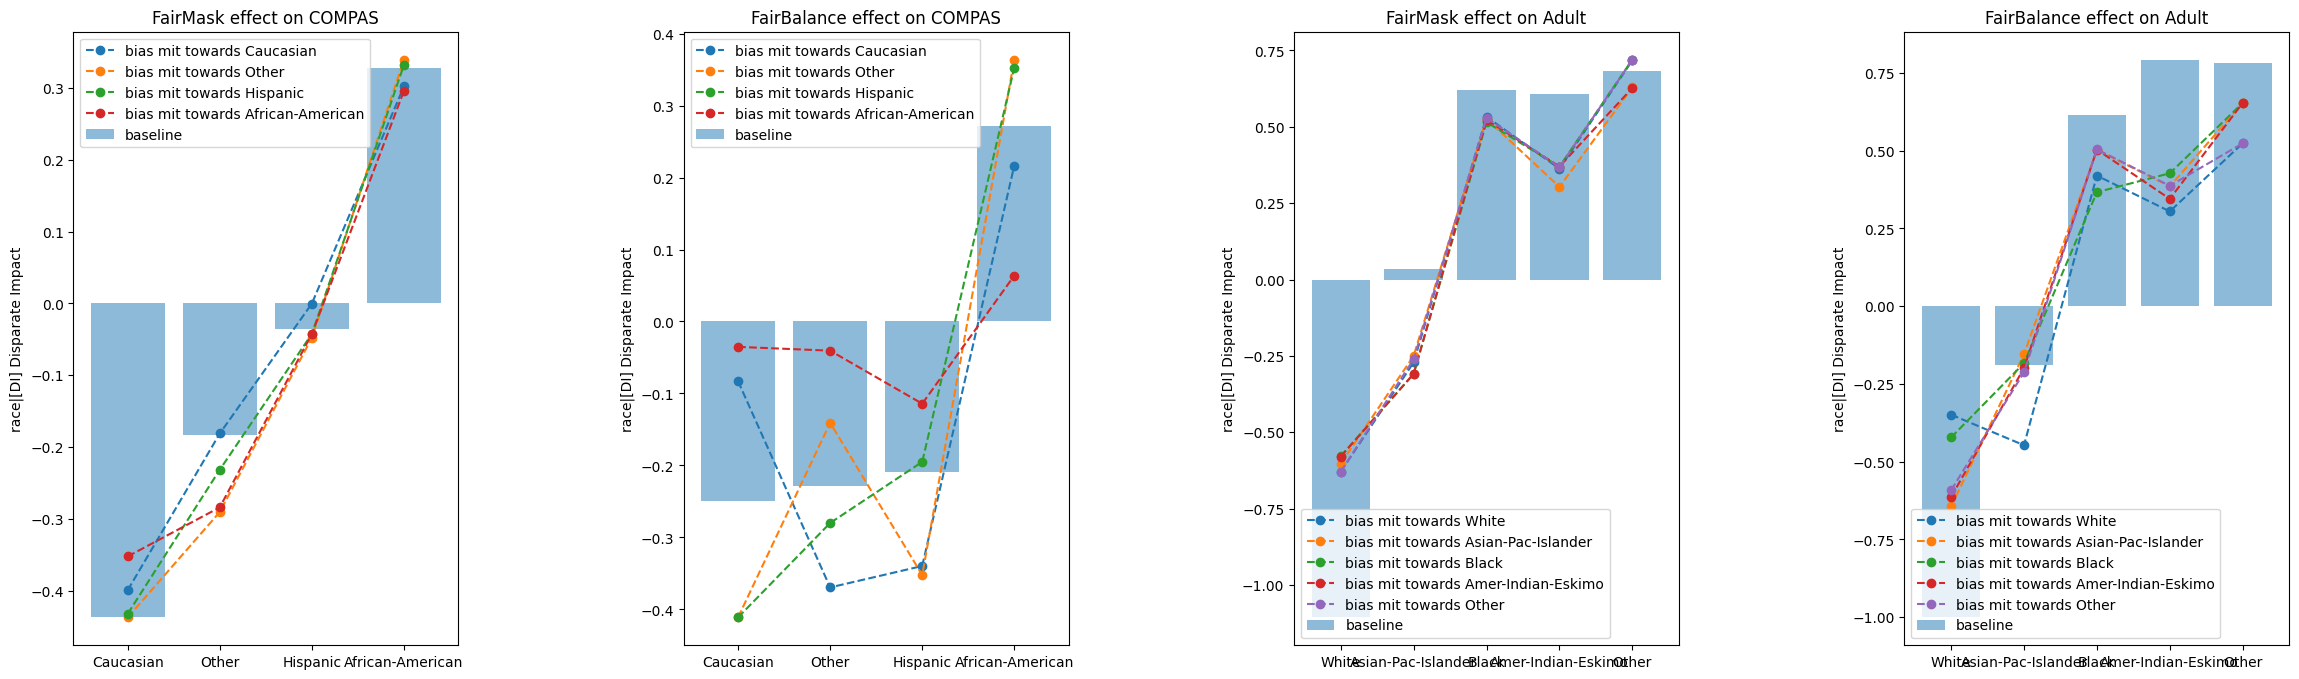

In [ ]:
reps = 1
metric =  'race|'+Metrics.DI
run_experiment_group(reps, metric, metrics_to_eval=[Metrics.DI])

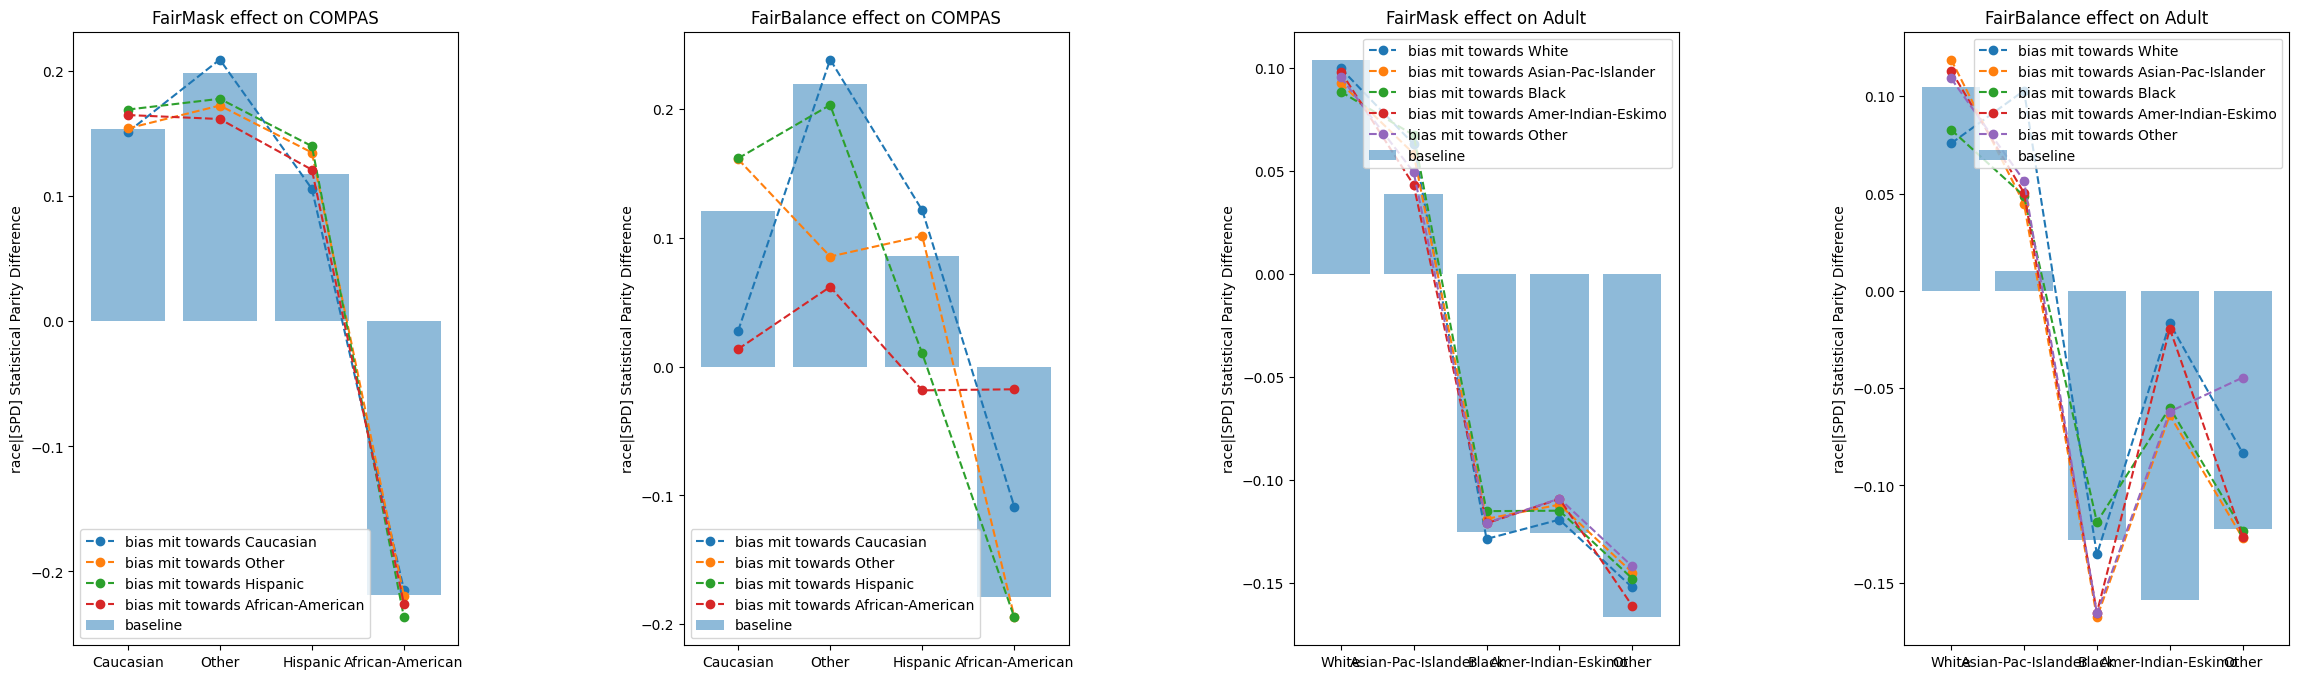

In [ ]:
reps = 1
metric =  'race|'+Metrics.SPD
run_experiment_group(reps, metric, metrics_to_eval=[Metrics.SPD])

In [ ]:
"""
OBSERVATIONS:

Fairmask does not do much on Compas (presumanbly cause data is so biased)
And does maybe a bit on Adult

Fairbalance just basically tweeks the treshold of positive vs negative outcomes. But just as before groups are discriminated at similar proportions


A different ML method does not really do much to change this as the logib behind this remains the same.
Mayhaps it changes how much the undersampled grops are discriminated against but thats it. 

In every single one of the cases there are subgroups for whom discrimination is iincreased in every example!

TODO:
see what if we ignore gender vs dont
combine some tiny groups into Other
what metric works the best on disproportionate groups
report variance.

"""
pass

## RUNNING EXPERIMENTS WITH FEWER RACES

In [ ]:
mls = { # bias mitigation method, ML algo, secondary ML alg, preprocessing, other
    "FB Baseline":(Tester.BASE_ML,      Model.LG_R, None, "FairBalance merge races", other_fb), 
    "FairBalance":(Tester.FAIRBALANCE,  Model.LG_R, None, "FairBalance merge races", other_fb), 

    "FM Baseline":(Tester.BASE_ML,      Model.RF_C, None,       "FairMask merge races",    other), 
    "FairMask":   (Tester.FAIRMASK,     Model.RF_C, Model.DT_R, "FairMask merge races",    other)
}

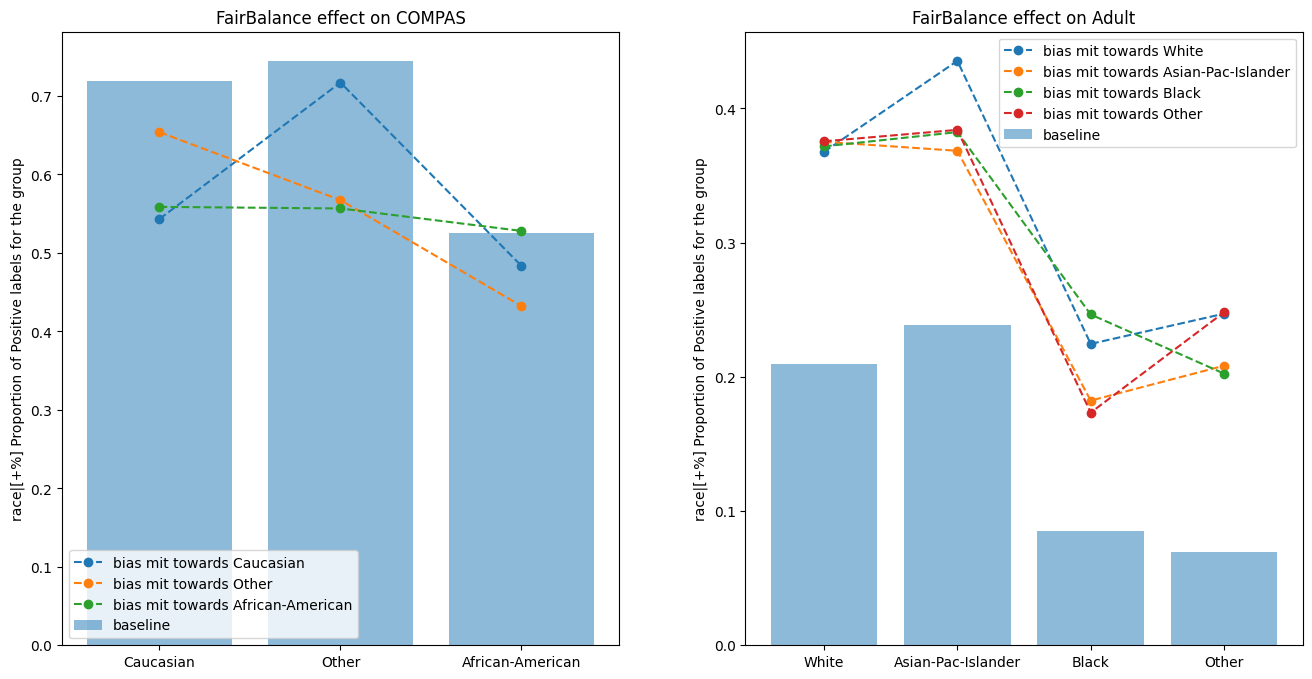

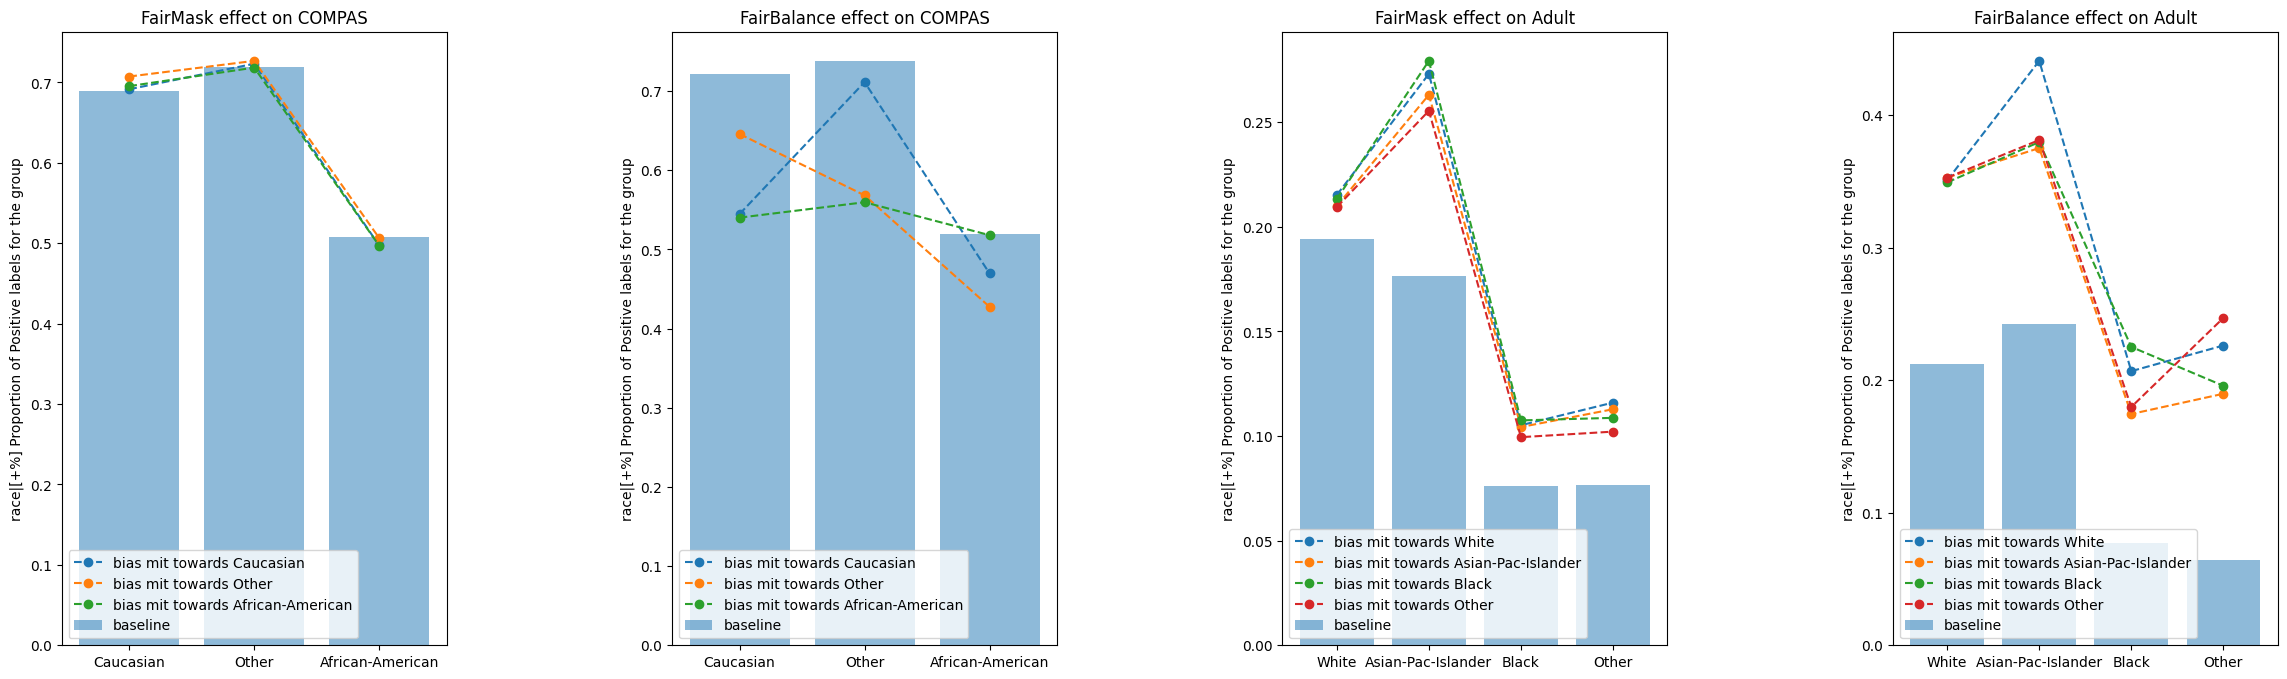

In [ ]:
# proportion of positive lables for each race for one run
reps = 20
metric = 'race|'+Metrics.POS
m_to_eval = Metrics.POS
run_fb_experiment_group(reps, metric, mls, ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
run_experiment_group(reps, metric, mls, metrics_to_eval=[m_to_eval])

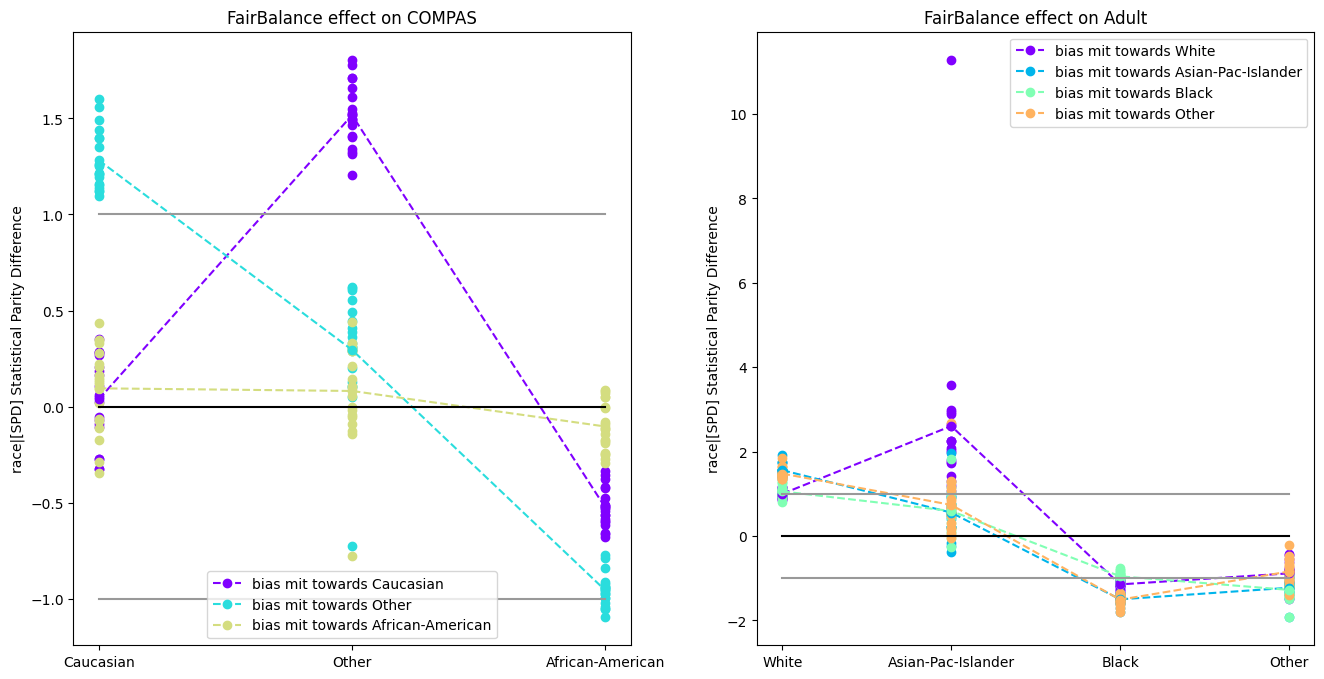

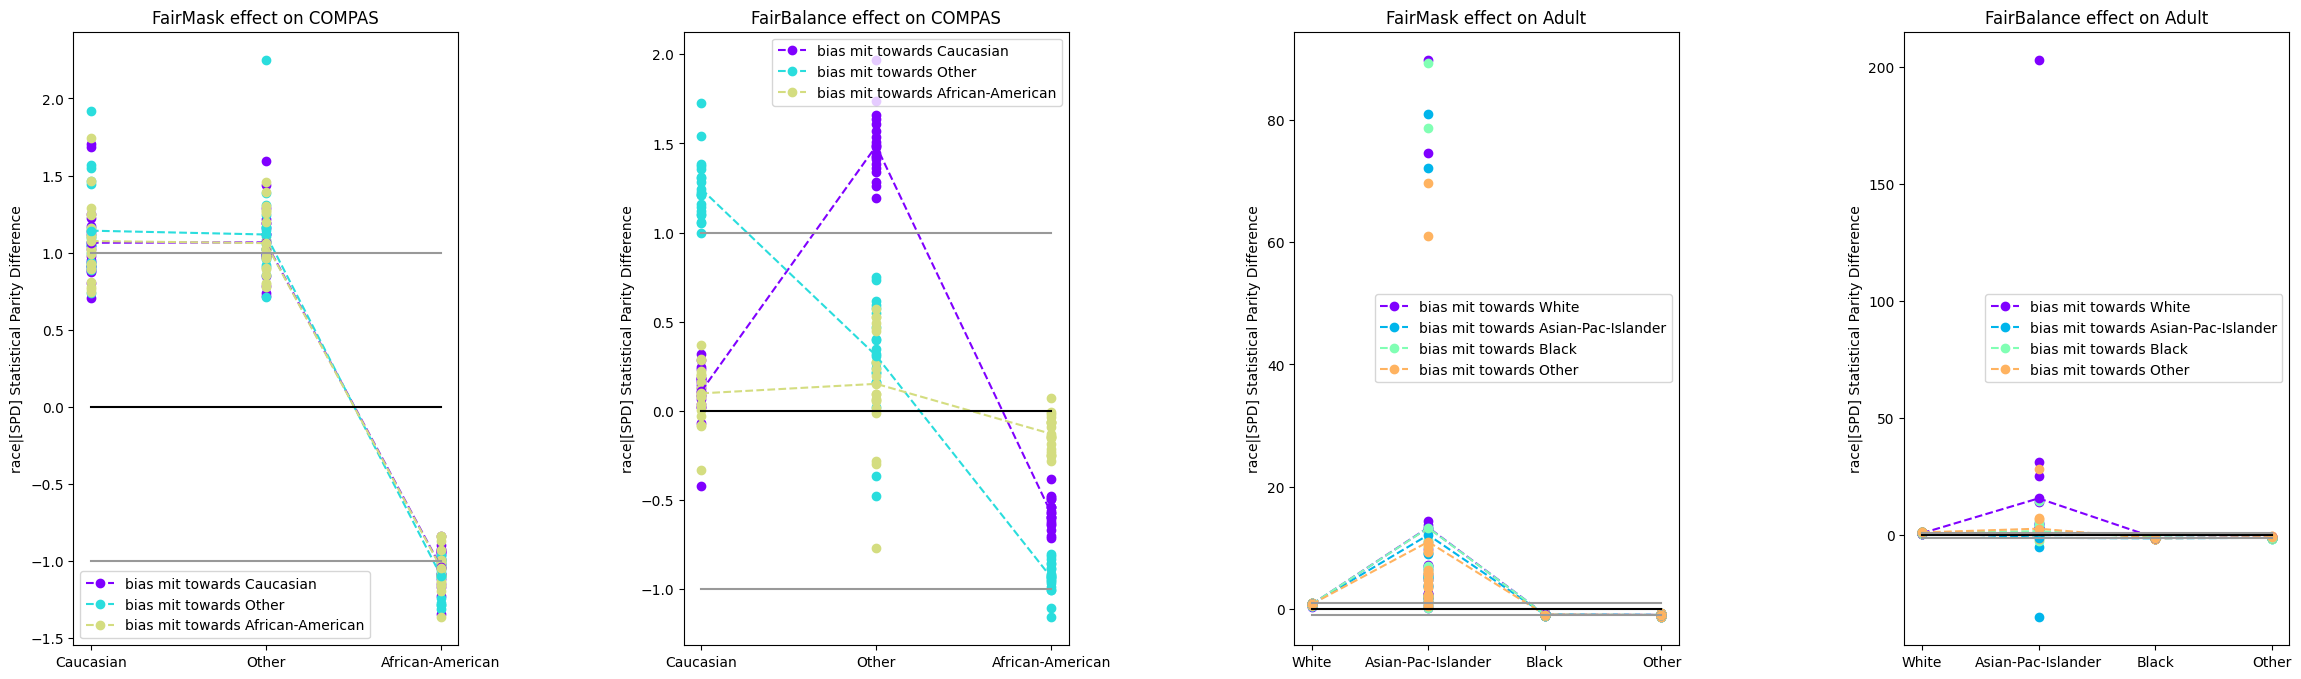

In [ ]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 20
metric =  'race|'+Metrics.SPD
m_to_eval = Metrics.SPD
run_change_fb_experiment_group(reps, metric, mls, ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
run_change_experiment_group(reps, metric, mls, metrics_to_eval=[m_to_eval])